In [6]:
from typing import Optional, Union, Tuple, List
import math
import array
import fractions
import logging
import numpy as np

from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.circuit import Gate, Instruction, ParameterVector
from qiskit.circuit.library import QFT
# from qiskit.providers import BaseBackend
# from qiskit.providers import Backend
from qiskit.quantum_info import partial_trace
# from qiskit.utils import summarize_circuits

from qiskit_aer import Aer
from qiskit import transpile
from qiskit.exceptions import QiskitError
# from qiskit.utils.arithmetic import is_power
# from qiskit.utils.validation import validate_min
# from qiskit.utils.quantum_instance import QuantumInstance
# from ..algorithm_result import AlgorithmResult
# from ..exceptions import AlgorithmError

logger = logging.getLogger(__name__)

In [7]:
def is_power(num, return_decomposition=False):
    """
    Check if num is a perfect power in O(n^3) time, n=ceil(logN)
    """
    b = 2
    while (2 ** b) <= num:
        a = 1
        c = num
        while (c - a) >= 2:
            m = int((a + c) / 2)

            if (m ** b) < (num + 1):
                p = int((m ** b))
            else:
                p = int(num + 1)

            if int(p) == int(num):
                if return_decomposition:
                    return True, int(m), int(b)
                else:
                    return True

            if p < num:
                a = int(m)
            else:
                c = int(m)
        b = b + 1
    if return_decomposition:
        return False, num, 1
    else:
        return False


In [8]:
def validate_min(name: str, value: float, minimum: float) -> None:
    """
    Args:
        name: value name.
        value: value to check.
        minimum: minimum value allowed.
    Raises:
        ValueError: invalid value
    """
    if value < minimum:

        raise ValueError('{} must have value >= {}, was {}'.format(name, minimum, value))

In [16]:
from qiskit_aer import Aer
quantum_backend_default = Aer.get_backend('qasm_simulator')

class Shor:
    """Shor's factoring algorithm.

    Shor's Factoring algorithm is one of the most well-known quantum algorithms and finds the
    prime factors for input integer :math:`N` in polynomial time.

    Adapted from https://github.com/ttlion/ShorAlgQiskit

    See also https://arxiv.org/abs/quant-ph/0205095
    """

    def __init__(self, backend):
        
        self._quantum_backend = backend

        if self._quantum_backend is None:
            # Crea un backend por defecto si no se proporciona uno
            # ... (código para crear el backend por defecto) ...
            # Por ejemplo:
            self._quantum_backend = quantum_backend_default
            print("Usando backend por defecto")
        else:
            self._quantum_backend = backend
            print("Usando backend proporcionado")

        # ... (resto del código del método __init__) ...

        self._n = None  # type: Optional[int]
        self._up_qreg = None
        self._down_qreg = None  # type: Optional[QuantumRegister]
        self._aux_qreg = None  # type: Optional[QuantumRegister]

        self._qft = QFT(do_swaps=False).to_instruction()
        self._iqft = self._qft.inverse()

        self._phi_add_N = None  # type: Optional[Gate]
        self._iphi_add_N = None

    @property
    def quantum_backend(self):
        """ Returns quantum instance. """
        return self._quantum_backend
    
    @quantum_backend.setter
    def quantum_bakend(self, backend):
        self._quantum_backend = backend


    def _get_angles(self, a: int) -> np.ndarray:
        """Calculates the array of angles to be used in the addition in Fourier Space."""
        s = bin(int(a))[2:].zfill(self._n + 1)
        angles = np.zeros([self._n + 1])
        for i in range(0, self._n + 1):
            for j in range(i, self._n + 1):
                if s[j] == '1':
                    angles[self._n - i] += math.pow(2, -(j - i))
            angles[self._n - i] *= np.pi
        return angles[::-1]

    @staticmethod
    def _phi_add_gate(size: int, angles: Union[np.ndarray, ParameterVector]) -> Gate:
        """Gate that performs addition by a in Fourier Space."""
        circuit = QuantumCircuit(size, name="phi_add")
        for i, angle in enumerate(angles):
            circuit.p(angle, i)
        return circuit.to_gate()

    def _double_controlled_phi_add_mod_N(self,
                                         num_qubits: int,
                                         angles: Union[np.ndarray, ParameterVector]
                                         ) -> QuantumCircuit:
        """Creates a circuit which implements double-controlled modular addition by a."""
        circuit = QuantumCircuit(num_qubits, name="ccphi_add_mod_N")

        ctl_up = 0
        ctl_down = 1
        ctl_aux = 2

        # get qubits from aux register, omitting the control qubit
        qubits = range(3, num_qubits)

        # store the gates representing addition/subtraction by a in Fourier Space
        phi_add_a = self._phi_add_gate(len(qubits), angles)
        iphi_add_a = phi_add_a.inverse()

        circuit.append(phi_add_a.control(2), [ctl_up, ctl_down, *qubits])
        circuit.append(self._iphi_add_N, qubits)
        circuit.append(self._iqft, qubits)

        circuit.cx(qubits[0], ctl_aux)

        circuit.append(self._qft, qubits)
        circuit.append(self._phi_add_N, qubits)
        circuit.append(iphi_add_a.control(2), [ctl_up, ctl_down, *qubits])
        circuit.append(self._iqft, qubits)

        circuit.x(qubits[0])
        circuit.cx(qubits[0], ctl_aux)
        circuit.x(qubits[0])

        circuit.append(self._qft, qubits)
        circuit.append(phi_add_a.control(2), [ctl_up, ctl_down, *qubits])
        return circuit

    def _controlled_multiple_mod_N(self, num_qubits: int, N: int, a: int) -> Instruction:
        """Implements modular multiplication by a as an instruction."""
        circuit = QuantumCircuit(
            num_qubits, name="multiply_by_{}_mod_{}".format(a % N, N)
        )
        down = circuit.qubits[1: self._n + 1]
        aux = circuit.qubits[self._n + 1:]
        qubits = [aux[i] for i in reversed(range(self._n + 1))]
        ctl_up = 0
        ctl_aux = aux[-1]

        angle_params = ParameterVector("angles", length=len(aux) - 1)
        double_controlled_phi_add = self._double_controlled_phi_add_mod_N(
            len(aux) + 2, angle_params
        )
        idouble_controlled_phi_add = double_controlled_phi_add.inverse()

        circuit.append(self._qft, qubits)

        # perform controlled addition by a on the aux register in Fourier space
        for i, ctl_down in enumerate(down):
            a_exp = (2 ** i) * a % N
            angles = self._get_angles(a_exp)
            bound = double_controlled_phi_add.assign_parameters({angle_params: angles})
            circuit.append(bound, [ctl_up, ctl_down, ctl_aux, *qubits])

        circuit.append(self._iqft, qubits)

        # perform controlled subtraction by a in Fourier space on both the aux and down register
        for j in range(self._n):
            circuit.cswap(ctl_up, down[j], aux[j])
        circuit.append(self._qft, qubits)

        a_inv = self.modinv(a, N)
        for i in reversed(range(len(down))):
            a_exp = (2 ** i) * a_inv % N
            angles = self._get_angles(a_exp)
            bound = idouble_controlled_phi_add.assign_parameters({angle_params: angles})
            circuit.append(bound, [ctl_up, down[i], ctl_aux, *qubits])

        circuit.append(self._iqft, qubits)
        return circuit.to_instruction()

    def construct_circuit(self,
                          N: int,
                          a: int = 2,
                          measurement: bool = False) -> QuantumCircuit:
        """Construct circuit.

        Args:
            N: The integer to be factored, has a min. value of 3.
            a: Any integer that satisfies 1 < a < N and gcd(a, N) = 1.
            measurement: Boolean flag to indicate if measurement should be included in the circuit.

        Returns:
            Quantum circuit.

        Raises:
            ValueError: Invalid N
        """
        validate_min('N', N, 3)
        validate_min('a', a, 2)

        # check the input integer
        if N < 1 or N % 2 == 0:
            raise ValueError('The input needs to be an odd integer greater than 1.')

        if a >= N or math.gcd(a, N) != 1:
            raise ValueError('The integer a needs to satisfy a < N and gcd(a, N) = 1.')

        # Get n value used in Shor's algorithm, to know how many qubits are used
        self._n = math.ceil(math.log(N, 2))
        self._qft.num_qubits = self._n + 1
        self._iqft.num_qubits = self._n + 1

        # quantum register where the sequential QFT is performed
        self._up_qreg = QuantumRegister(2 * self._n, name='up')
        # quantum register where the multiplications are made
        self._down_qreg = QuantumRegister(self._n, name='down')
        # auxiliary quantum register used in addition and multiplication
        self._aux_qreg = QuantumRegister(self._n + 2, name='aux')

        # Create Quantum Circuit
        circuit = QuantumCircuit(self._up_qreg,
                                 self._down_qreg,
                                 self._aux_qreg,
                                 name="Shor(N={}, a={})".format(N, a))

        # Create gates to perform addition/subtraction by N in Fourier Space
        self._phi_add_N = self._phi_add_gate(self._aux_qreg.size - 1, self._get_angles(N))
        self._iphi_add_N = self._phi_add_N.inverse()

        # Create maximal superposition in top register
        circuit.h(self._up_qreg)

        # Initialize down register to 1
        circuit.x(self._down_qreg[0])

        # Apply the multiplication gates as showed in
        # the report in order to create the exponentiation
        for i, ctl_up in enumerate(self._up_qreg):  # type: ignore
            a_aux = int(pow(a, pow(2, i)))
            controlled_multiple_mod_N = self._controlled_multiple_mod_N(
                len(self._down_qreg) + len(self._aux_qreg) + 1, N, a_aux,
            )
            circuit.append(
                controlled_multiple_mod_N, [ctl_up, *self._down_qreg, *self._aux_qreg]
            )

        # Apply inverse QFT
        iqft = QFT(len(self._up_qreg)).inverse().to_instruction()
        circuit.append(iqft, self._up_qreg)

        if measurement:
            up_cqreg = ClassicalRegister(2 * self._n, name='m')
            circuit.add_register(up_cqreg)
            circuit.measure(self._up_qreg, up_cqreg)

        logger.info(f"summarize_circuits({circuit})")

        return circuit

    @staticmethod
    def modinv(a: int, m: int) -> int:
        """Returns the modular multiplicative inverse of a with respect to the modulus m."""
        def egcd(a: int, b: int) -> Tuple[int, int, int]:
            if a == 0:
                return b, 0, 1
            else:
                g, y, x = egcd(b % a, a)
                return g, x - (b // a) * y, y

        g, x, _ = egcd(a, m)
        if g != 1:
            raise ValueError("The greatest common divisor of {} and {} is {}, so the "
                             "modular inverse does not exist.".format(a, m, g))
        return x % m

    def _get_factors(self, N: int, a: int, measurement: str) -> Optional[List[int]]:
        """Apply the continued fractions to find r and the gcd to find the desired factors."""
        x_final = int(measurement, 2)
        logger.info('In decimal, x_final value for this result is: %s.', x_final)

        if x_final <= 0:
            fail_reason = 'x_final value is <= 0, there are no continued fractions.'
        else:
            fail_reason = None
            logger.debug('Running continued fractions for this case.')

        # Calculate T and x/T
        T_upper = len(measurement)
        T = pow(2, T_upper)
        x_over_T = x_final / T

        # Cycle in which each iteration corresponds to putting one more term in the
        # calculation of the Continued Fraction (CF) of x/T

        # Initialize the first values according to CF rule
        i = 0
        b = array.array('i')
        t = array.array('f')

        b.append(math.floor(x_over_T))
        t.append(x_over_T - b[i])

        exponential = 0.0
        while i < N and fail_reason is None:
            # From the 2nd iteration onwards, calculate the new terms of the CF based
            # on the previous terms as the rule suggests
            if i > 0:
                b.append(math.floor(1 / t[i - 1]))
                t.append((1 / t[i - 1]) - b[i])  # type: ignore

            # Calculate the denominator of the CF using the known terms
            denominator = self._calculate_continued_fraction(b)

            # Increment i for next iteration
            i += 1

            if denominator % 2 == 1:
                logger.debug('Odd denominator, will try next iteration of continued fractions.')
                continue

            # Denominator is even, try to get factors of N
            # Get the exponential a^(r/2)

            if denominator < 1000:
                exponential = pow(a, denominator / 2)

            # Check if the value is too big or not
            if exponential > 1000000000:
                fail_reason = 'denominator of continued fraction is too big.'
            else:
                # The value is not too big,
                # get the right values and do the proper gcd()
                putting_plus = int(exponential + 1)
                putting_minus = int(exponential - 1)
                one_factor = math.gcd(putting_plus, N)
                other_factor = math.gcd(putting_minus, N)

                # Check if the factors found are trivial factors or are the desired factors
                if any(factor in {1, N} for factor in (one_factor, other_factor)):
                    logger.debug('Found just trivial factors, not good enough.')
                    # Check if the number has already been found,
                    # (use i - 1 because i was already incremented)
                    if t[i - 1] == 0:
                        fail_reason = 'the continued fractions found exactly x_final/(2^(2n)).'
                else:
                    # Successfully factorized N
                    return sorted((one_factor, other_factor))

        # Search for factors failed, write the reason for failure to the debug logs
        logger.debug(
            'Cannot find factors from measurement %s because %s',
            measurement, fail_reason or 'it took too many attempts.'
        )
        return None

    @staticmethod
    def _calculate_continued_fraction(b: array.array) -> int:
        """Calculate the continued fraction of x/T from the current terms of expansion b."""

        x_over_T = 0

        for i in reversed(range(len(b) - 1)):
            x_over_T = 1 / (b[i + 1] + x_over_T)

        x_over_T += b[0]

        # Get the denominator from the value obtained
        frac = fractions.Fraction(x_over_T).limit_denominator()

        logger.debug('Approximation number %s of continued fractions:', len(b))
        logger.debug("Numerator:%s \t\t Denominator: %s.", frac.numerator, frac.denominator)
        return frac.denominator

    def factor(self,
               N: int,
               a: int = 2,
               ) -> 'ShorResult':
        """Execute the algorithm.

        The input integer :math:`N` to be factored is expected to be odd and greater than 2.
        Even though this implementation is general, its capability will be limited by the
        capacity of the simulator/hardware. Another input integer :math:`a`  can also be supplied,
        which needs to be a co-prime smaller than :math:`N` .

        Args:
            N: The integer to be factored, has a min. value of 3.
            a: Any integer that satisfies 1 < a < N and gcd(a, N) = 1.

        Returns:
            ShorResult: results of the algorithm.

        Raises:
            ValueError: Invalid input
            AlgorithmError: If a quantum instance or backend has not been provided

        """
        validate_min('N', N, 3)
        validate_min('a', a, 2)

        # check the input integer
        if N < 1 or N % 2 == 0:
            raise ValueError('The input needs to be an odd integer greater than 1.')

        if a >= N or math.gcd(a, N) != 1:
            raise ValueError('The integer a needs to satisfy a < N and gcd(a, N) = 1.')

        if self.quantum_backend is None:
            raise QiskitError("A QuantumInstance or Backend "
                                 "must be supplied to run the quantum algorithm.")

        result = ShorResult()

        # check if the input integer is a power
        tf, b, p = is_power(N, return_decomposition=True)
        if tf:
            logger.info('The input integer is a power: %s=%s^%s.', N, b, p)
            result.factors.append(b)

        if not result.factors:
            logger.debug('Running with N=%s and a=%s.', N, a)

            circuit = self.construct_circuit(N=N, a=a, measurement=True)
                        
            # compiled_circuit = transpile(circuit, self.quantum_backend)
            #job = self.quantum_backend.run(compiled_circuit, shots=1)
            #counts = job.result().get_counts(circuit)

            #result.total_counts = len(counts)

            # For each simulation result, print proper info to user
            # and try to calculate the factors of N
            
        return circuit


class ShorResult():
    """ Shor Result."""

    def __init__(self) -> None:
        super().__init__()
        self._factors = []
        self._total_counts = 0
        self._successful_counts = 0

    @property
    def factors(self) -> List[List[int]]:
        """ returns factors """
        return self._factors

    @factors.setter
    def factors(self, value: List[List[int]]) -> None:
        """ set factors """
        self._factors = value

    @property
    def total_counts(self) -> int:
        """ returns total counts """
        return self._total_counts

    @total_counts.setter
    def total_counts(self, value: int) -> None:
        """ set total counts """
        self._total_counts = value

    @property
    def successful_counts(self) -> int:
        """ returns successful counts """
        return self._successful_counts

    @successful_counts.setter
    def successful_counts(self, value: int) -> None:
        """ set successful counts """
        self._successful_counts = value


In [25]:
# Número a factorizar
N = 15

# Instanciar el algoritmo de Shor
shor = Shor(quantum_backend_default)

# Ejecutar el algoritmo de Shor
result = shor.factor(N)

Usando backend proporcionado


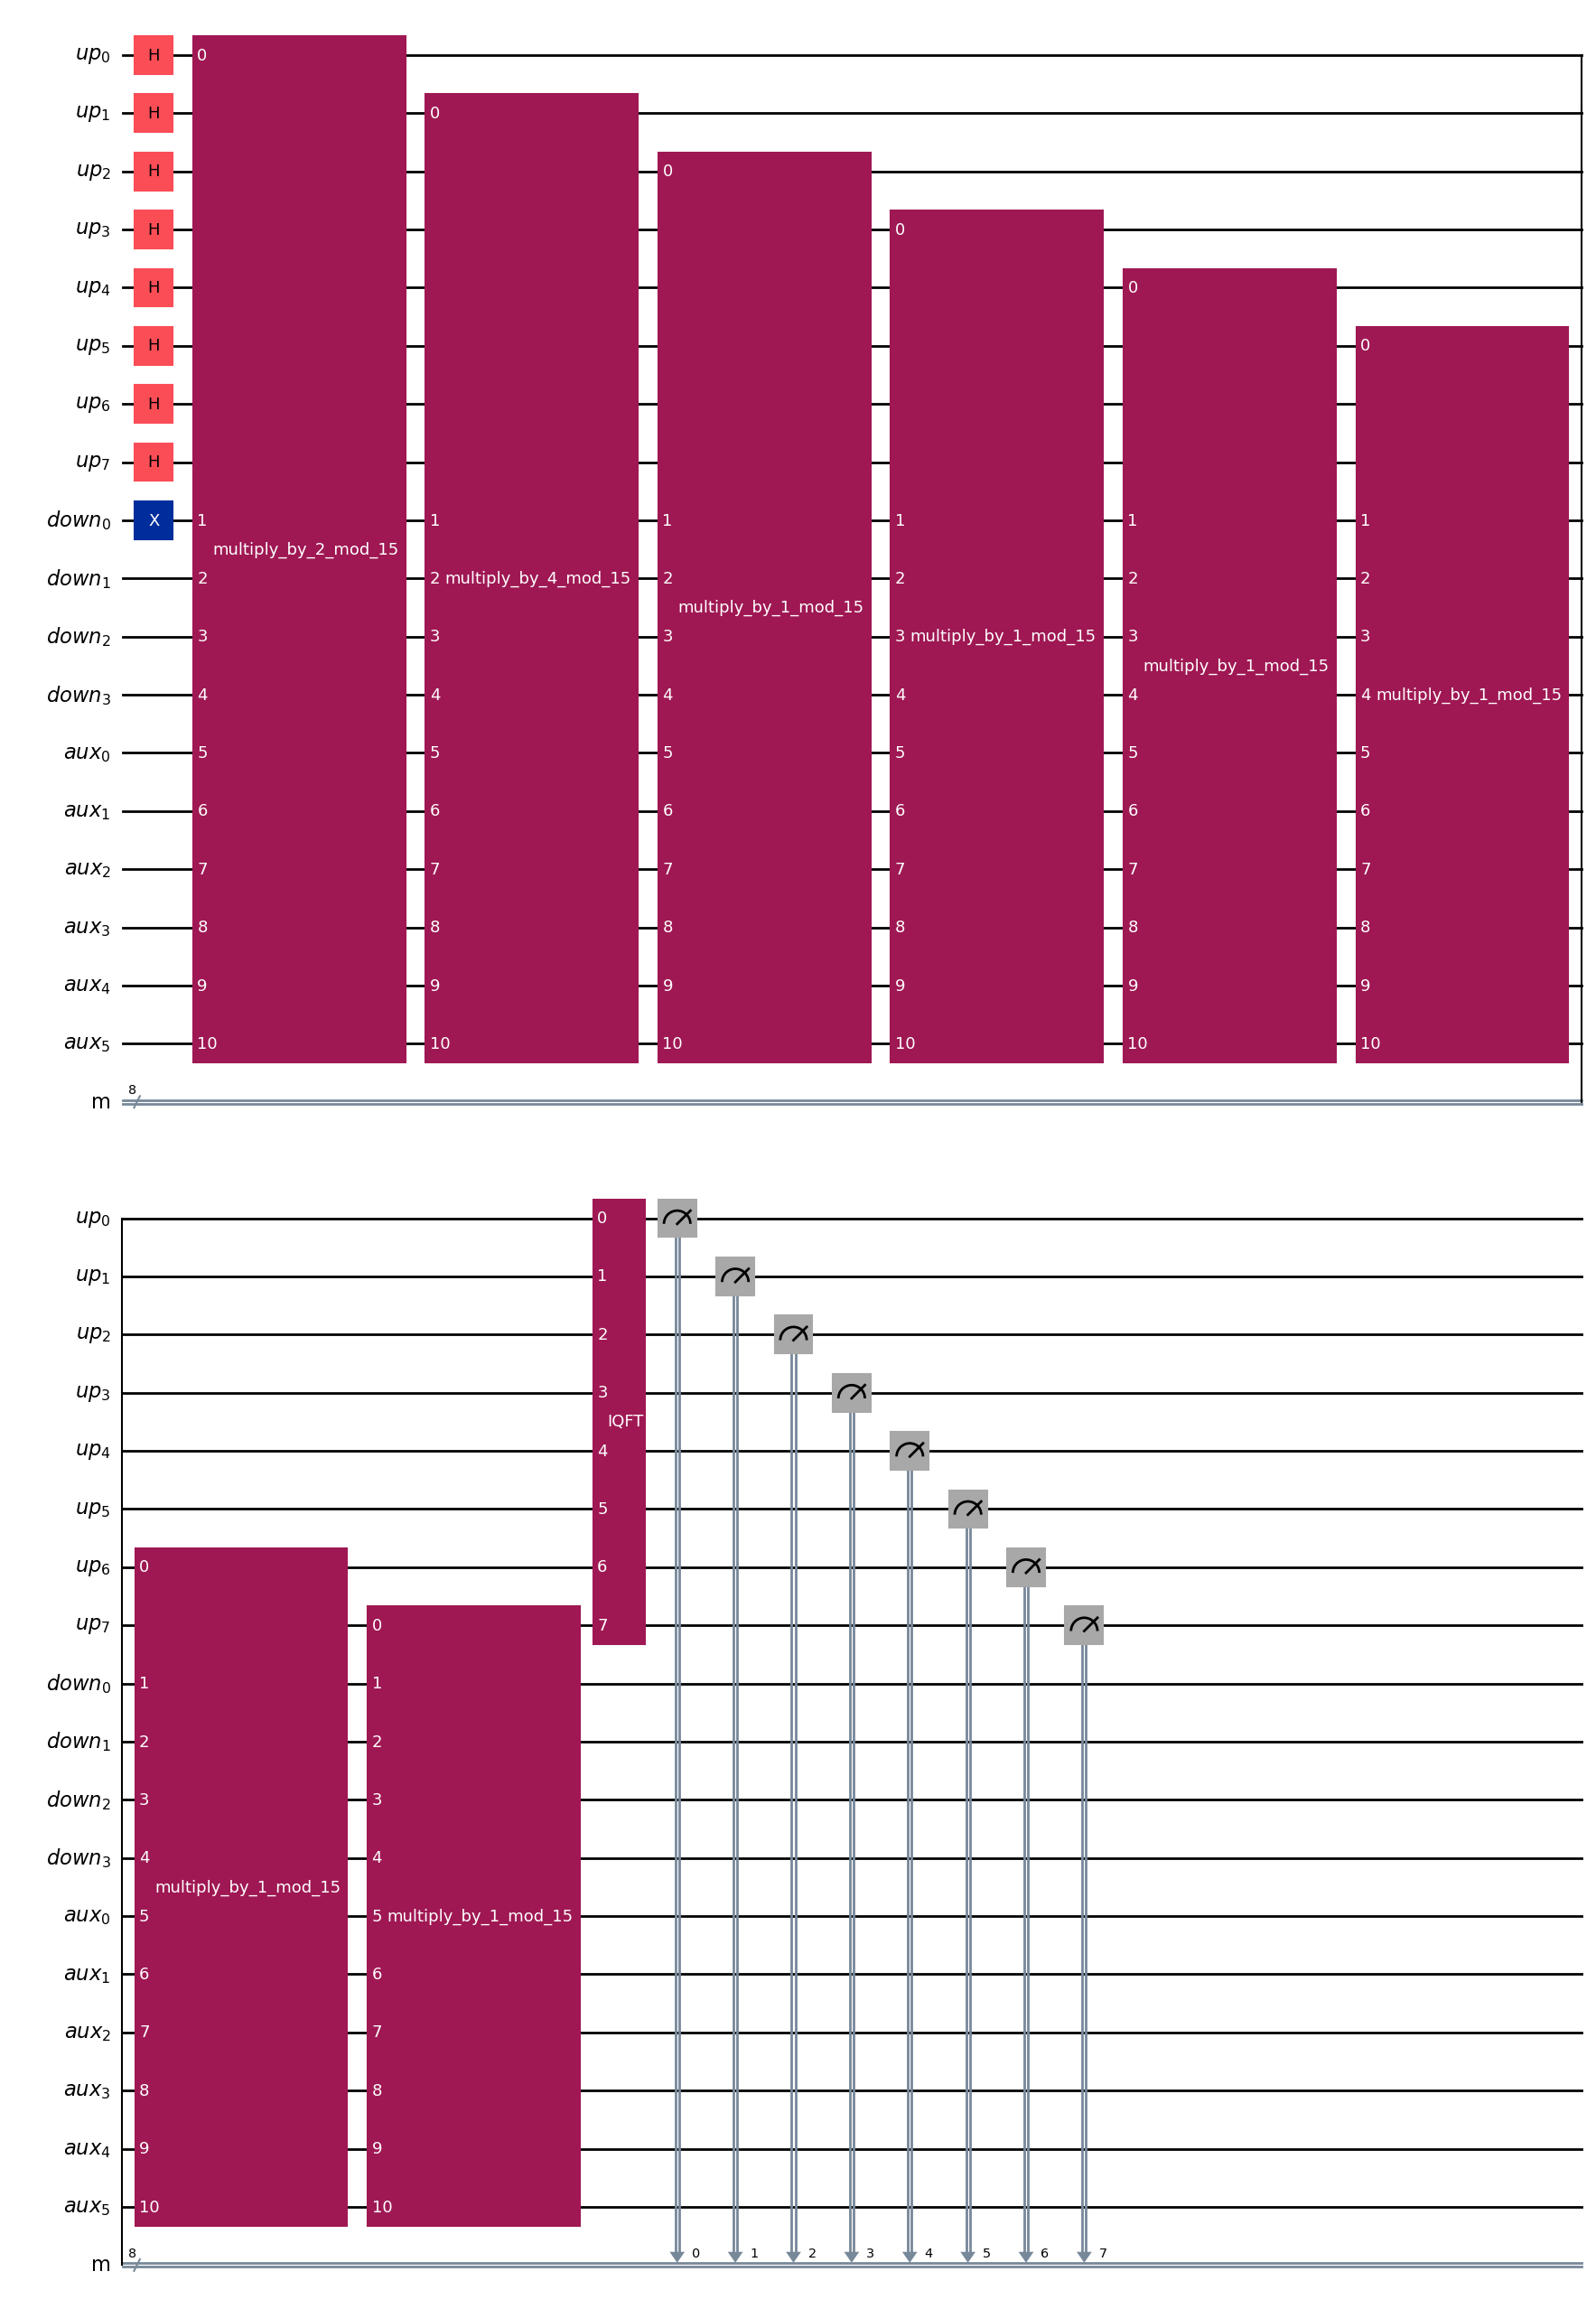

In [26]:
result.draw(output='mpl')


In [ ]:
# check if the input integer is a power
        tf, b, p = is_power(N, return_decomposition=True)
        if tf:
            logger.info('The input integer is a power: %s=%s^%s.', N, b, p)
            result.factors.append(b)

        if not result.factors:
            logger.debug('Running with N=%s and a=%s.', N, a)

            circuit = self.construct_circuit(N=N, a=a, measurement=True)
            compiled_circuit = transpile(circuit, self.quantum_backend)
            job = self.quantum_backend.run(compiled_circuit, shots=1)
            counts = job.result().get_counts(circuit)

            result.total_counts = len(counts)

            # For each simulation result, print proper info to user
            # and try to calculate the factors of N
            for measurement in list(counts.keys()):
                # Get the x_final value from the final state qubits
                logger.info("------> Analyzing result %s.", measurement)
                factors = self._get_factors(N, a, measurement)

                if factors:
                    logger.info(
                        'Found factors %s from measurement %s.',
                        factors, measurement
                    )
                    result.successful_counts = result.successful_counts + 1
                    if factors not in result.factors:
                        result.factors.append(factors)
